# Feature Selection

## 1.&nbsp; Dataset Creation

We will start by creating a dataset with many features. We will purposefully create a dataset with some good columns (columns that have a relationship with the label) and some bad columns (columns without any relationship whatsoever with the label) to illustrate how Feature Selection works.

Bear in mind that the effectiveness of the feature selection methods depends largely on the dataset you're applying them to: if we were to have a dataset where ALL features have a meaningful relationship with the label, then dropping them would be counter-productive.

Having said that, you do not need to understand (or look into) how we create the dataset.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, MaxAbsScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from  sklearn.ensemble import RandomForestRegressor


In [ ]:
url = 'https://drive.google.com/file/d/1ekP1Q-479fnlf1qzgTm5NAYBERSzA8Vs/view?usp=sharing' # train.csv
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
house = pd.read_csv(path)

house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Train-Test Split

In [ ]:
X = house.drop(columns=['Id','SalePrice'])
y = house['SalePrice']

X = X.select_dtypes(exclude="object").copy()

# Imputing the mean
num_imputer = SimpleImputer(strategy="mean").set_output(transform='pandas')

# Fitting and transforming
X= num_imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
618,20.0,90.000000,11694.0,9.0,5.0,2007.0,2007.0,452.0,48.0,0.0,...,774.0,0.0,108.0,0.0,0.0,260.0,0.0,0.0,7.0,2007.0
870,20.0,60.000000,6600.0,5.0,5.0,1962.0,1962.0,0.0,0.0,0.0,...,308.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2009.0
92,30.0,80.000000,13360.0,5.0,7.0,1921.0,2006.0,0.0,713.0,0.0,...,432.0,0.0,0.0,44.0,0.0,0.0,0.0,0.0,8.0,2009.0
817,20.0,70.049958,13265.0,8.0,5.0,2002.0,2002.0,148.0,1218.0,0.0,...,857.0,150.0,59.0,0.0,0.0,0.0,0.0,0.0,7.0,2008.0
302,20.0,118.000000,13704.0,7.0,5.0,2001.0,2002.0,150.0,0.0,0.0,...,843.0,468.0,81.0,0.0,0.0,0.0,0.0,0.0,1.0,2006.0


### 4.1. Data Scaling
As we just saw, the large variance of columns 25 and 26 might be due to the fact that their values cover a bigger range. This means though that their variances cannot be compared well with those of the other columns.

Therefore, it's a good idea to scale the features before removing those with the smallest variance.

Some scaling processes (e.g. standardization) transform features in such a way that they all end up having the same variance. This is **not** what we want! It is important to pick a scaler that does not do that. We will use min-max scaling.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Initialize the scaler.
my_scaler = MinMaxScaler()

# Fit the scaler to X_train and transform the values.
X_train_scaled = my_scaler.fit_transform(X_train)

# X_test and transform the values.
X_test_scaled = my_scaler.transform(X_test)

# Create a DataFrame.
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)


# Create a DataFrame.
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## 5.&nbsp; Collinearity

Features that have a perfect (or extremely high) correlation with each other can be considered to be the same feature. We want to drop one of them. Let's first explore the pairwise correlations between all features.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

As a first step, let's drop the two columns with zero variance, i.e. those containing only a single, constant value. These columns would otherwise introduce bias into the correlation matrix.

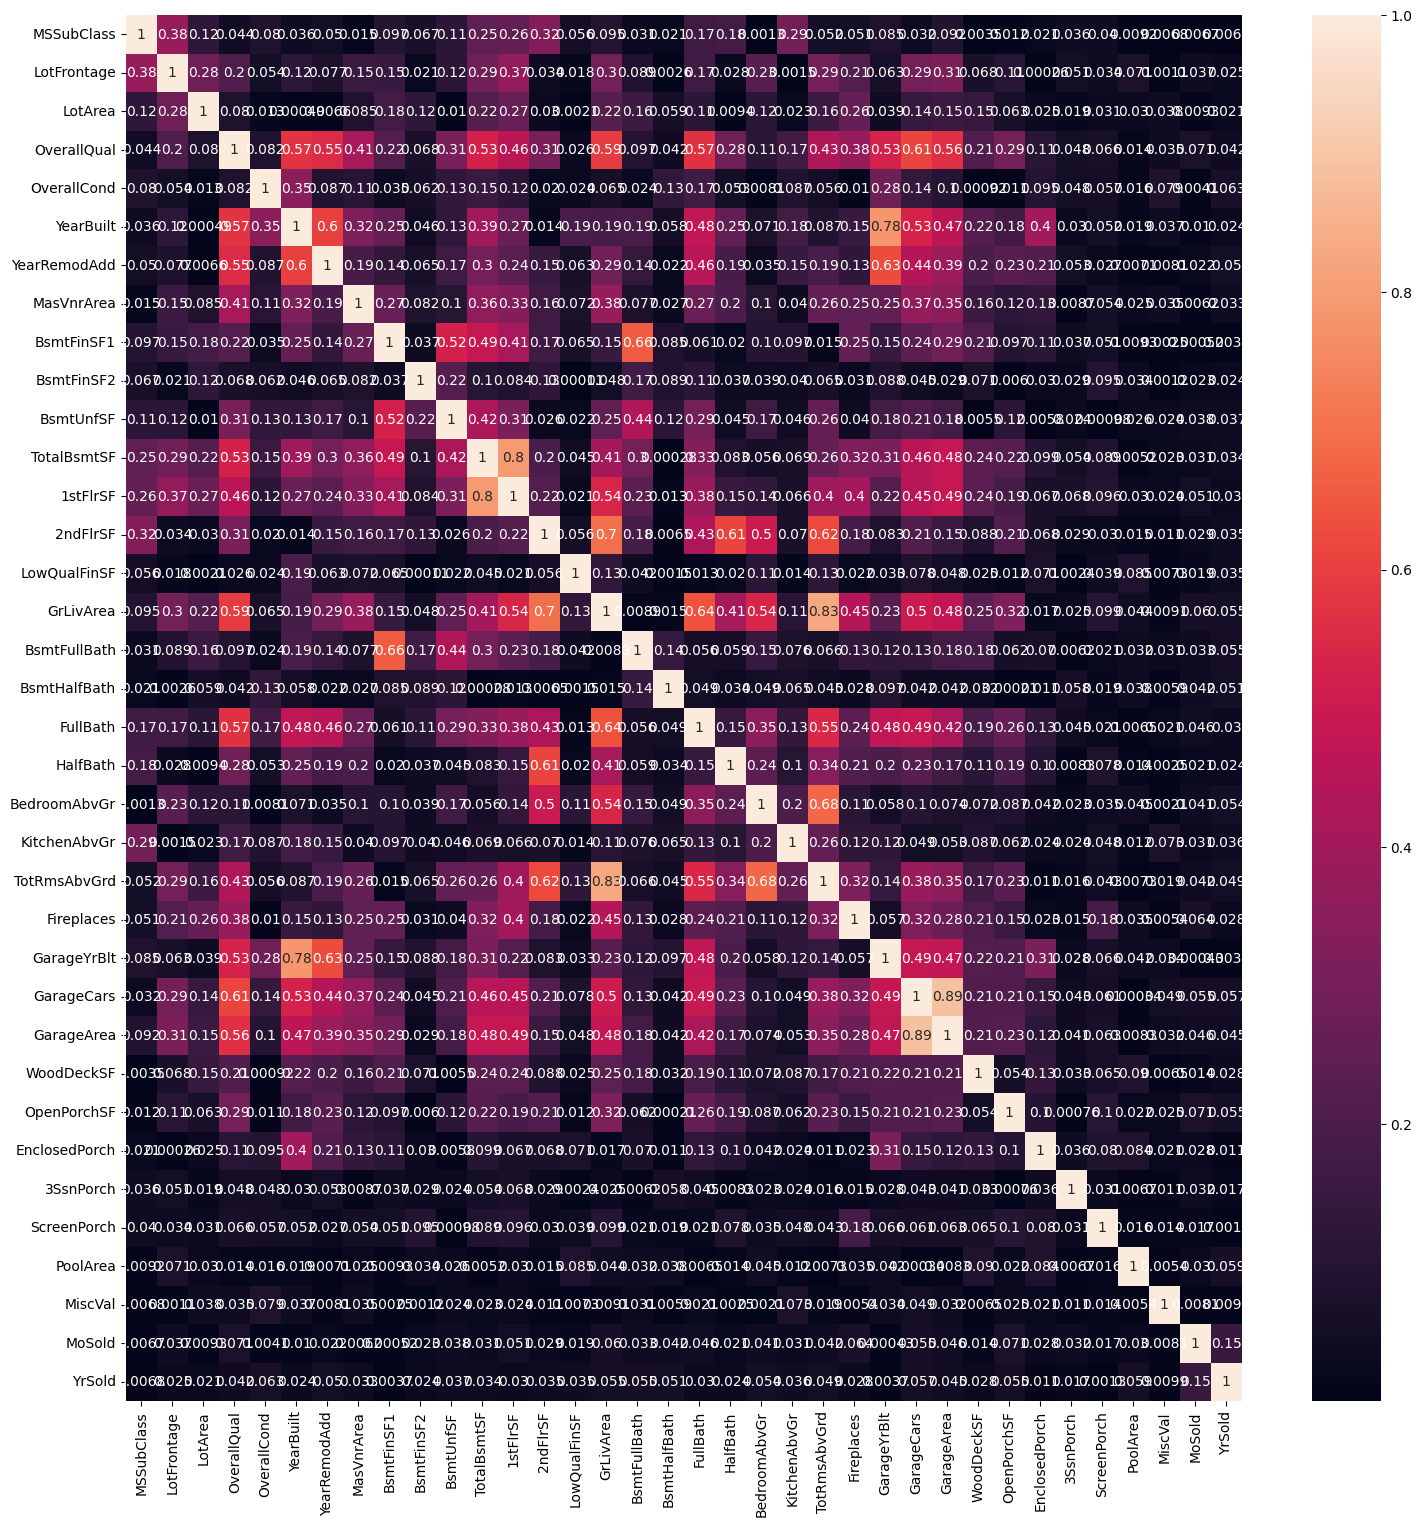

In [ ]:
# Create the correlation matrix, using the absolute values.
# For our purpose, it doesn't matter whether the correlation is positive or negative.
corrMatrix = X_train_scaled.corr().abs()

# Plot a heatmap of the correlation matrix.
fig, ax = plt.subplots(figsize=(18,18))
sns.heatmap(corrMatrix, annot=True);

We can see how there is a pair of columns with a _perfect_  correlation (`1`) and another pair of columns with a very high correlation (`0.96`). The rest of the correlation coefficients are much smaller and can be neglected at this stage.

We will now write code that identifies pairs of columns with a correlation coefficient above a certain threshold (defined by us) and drops one of them. Also, we will drop one of the two highly correlated columns arbitrarily. As an alternative, it is very well possible to go for a slightly more sophisticated approach and e.g. keep the column that has the higher correlation with the target. Keeping the mean would also be a viable option.

In [ ]:
# Select the upper triangle of the correlation matrix.
upper = corrMatrix.where(np.triu(np.ones(corrMatrix.shape), k=1).astype(bool))

upper

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
MSSubClass,NaN,0.378494,0.123917,0.044099,0.080481,0.035620,0.050409,0.014988,0.096674,0.066524,...,0.091990,0.003539,0.011817,0.021054,0.036057,0.039553,0.009155,0.006767,0.006746,0.006788
LotFrontage,NaN,NaN,0.279716,0.204780,0.054225,0.118215,0.076519,0.153581,0.150285,0.021137,...,0.313704,0.067651,0.106550,0.000257,0.050518,0.034130,0.070928,0.001091,0.036532,0.025422
LotArea,NaN,NaN,NaN,0.080157,0.012577,0.000488,0.006557,0.085125,0.177359,0.121701,...,0.154083,0.146674,0.062830,0.025418,0.018672,0.031347,0.029861,0.037509,0.009320,0.021434
OverallQual,NaN,NaN,NaN,NaN,0.082389,0.571103,0.551088,0.411424,0.215230,0.068193,...,0.563745,0.209237,0.294374,0.105706,0.048349,0.065978,0.013914,0.035270,0.071390,0.042099
OverallCond,NaN,NaN,NaN,NaN,NaN,0.346663,0.087446,0.107830,0.034612,0.062393,...,0.101029,0.000918,0.010697,0.094843,0.047955,0.056644,0.016213,0.078833,0.004114,0.063086
YearBuilt,NaN,NaN,NaN,NaN,NaN,NaN,0.599605,0.316522,0.254846,0.046149,...,0.466313,0.224738,0.175053,0.401756,0.030402,0.051583,0.019431,0.037278,0.009972,0.024260
YearRemodAdd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.190335,0.136540,0.065038,...,0.387651,0.196177,0.229872,0.208838,0.052884,0.026593,0.007083,0.008073,0.022282,0.049712
MasVnrArea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.268323,0.081729,...,0.354951,0.163840,0.119821,0.134565,0.008705,0.053723,0.024733,0.035338,0.006182,0.032522
BsmtFinSF1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.036529,...,0.286433,0.207534,0.096620,0.110234,0.037047,0.051237,0.009309,0.002495,0.000523,0.003703
BsmtFinSF2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.028965,0.071165,0.005977,0.029634,0.028792,0.094882,0.033941,0.001164,0.022681,0.024012


In [ ]:
# Find the index of those feature columns with correlation greater than 0.95.
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [ ]:
# Drop the columns from the train set.
X_train_selected = X_train_scaled.drop(columns=to_drop)

# Drop the columns from the test set.
X_test_selected = X_test_scaled.drop(columns=to_drop)

# Decision Tree

In [ ]:
# Decision tree.
tree = DecisionTreeRegressor()
tree.fit(X_train_selected, y_train)
tree_pred = tree.predict(X = X_test_selected)

# KNN

In [ ]:
# K-Nearest Neighbors.
knn = KNeighborsRegressor(n_neighbors=1)
knn.fit(X_train_selected, y_train)
knn_pred = knn.predict(X = X_test_selected)

# LinearRegression

In [ ]:
#Linearregression Model
lr = LinearRegression()
lr.fit(X_train_selected, y_train)
lr_pred = lr.predict(X = X_test_selected)

# RandomForestRegressor

In [ ]:
#Linearregression Model
rf = RandomForestRegressor()
rf.fit(X_train_selected, y_train)
rf_pred = rf.predict(X = X_test_selected)

# Calculate performance

In [ ]:
performances = pd.DataFrame(columns=["performance_tree", "performance_knn", "performace_linear", "performance_randomforest"])

In [ ]:
performances.loc["collinearity", "performance_tree"] = r2_score(y_test, tree_pred)
performances.loc["collinearity", "performance_knn"] = r2_score(y_test, knn_pred)
performances.loc["collinearity", "performance_linear"] = r2_score(y_test, lr_pred)
performances.loc["collinearity", "performance_randomforest"] = r2_score(y_test, rf_pred)
performances

,performance_tree,performance_knn,performace_linear,performance_randomforest,performance_linear
collinearity,0.609825,0.544164,NaN,0.828531,0.634778


## 9.&nbsp;Challenge Kaggle https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview

Try out several models and several features selection methods


Test the model on Kaggle testing dataset


Export the results and make a submition on Kaggle


Keep improving your model, the smaller the RMSE is, the better.

It is suggested to change the donwload name every time you have new model reulst.

file_name = 'sub_df.csv'
sub_df.to_csv(file_name,index=False)

files.download(file_name)



In [ ]:
url = 'https://drive.google.com/file/d/1J74X6lVngUWHOc-qIoQsH5qo5jqLoVGq/view?usp=share_link' # train.csv
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

X_test = pd.read_csv(path)

In [ ]:
X_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


# Missing values:

In [ ]:
X_test.isna().sum()

Id                 0
MSSubClass         0
MSZoning           4
LotFrontage      227
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 80, dtype: int64

In [ ]:
X_test.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [ ]:
X_train_selected.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [ ]:
test_ids = X_test.pop("Id")

In [ ]:
X_test = X_test[X_train_selected.columns]

# imputing missing values

In [ ]:
X_test_imputed = num_imputer.transform(X_test)

In [ ]:
preds = rf.predict(X_test_imputed)

In [ ]:
file_name = 'collinearity_randomforest.csv'

In [ ]:
collinearity_randomforest = pd.DataFrame({'Id':test_ids,'SalePrice':preds})
collinearity_randomforest.to_csv(file_name,index=False)

In [ ]:
collinearity_randomforest

,Id,SalePrice
0,1461,443673.27
1,1462,510670.30
2,1463,449041.98
3,1464,549122.40
4,1465,414108.26
...,...,...
1454,2915,430580.51
1455,2916,442563.68
1456,2917,452402.67
1457,2918,409346.20


In [ ]:
from google.colab import files
files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>